In [1]:
using PyPlot
using PyCall
using FITSIO
using Interpolations
using Optim
using Base.Iterators: take
@pyimport camb

## Parameters of the fiducial model

In [2]:
τ   = 0.055
Aₛ  = 1.882 * exp(2τ) * 1e-9
nₛ  = 0.9645
H₀  = 67.27
h   = H₀/100
ωb  = 0.02225
ωc  = 0.1198
Σmν = 0.06

kₚ  = 0.05
T₀  = 2.7255;

## Planck

### Compute CMB transfer functions

Here we call CAMB to compute the CMB and matter transfer functions. Note we're computing them at every $\ell$ and at somewhat higher accuracy than normal, so this step may take a few minutes. 

In [3]:
p = camb.set_params(
    As=Aₛ, ns=nₛ, H0=H₀, ombh2=ωb, omch2=ωc, tau=τ, mnu=Σmν, 
    pivot_scalar=kₚ, AccuracyBoost=2, lSampleBoost=50, TCMB=T₀, redshifts=[0], k_eta_fac=10, lmax=2600
)
r = camb.get_results(p)
t = r[:get_cmb_transfer_data]()
mt = r[:get_matter_transfer_data]();

In [4]:
ℓs = 1:2508
toCℓ = @. 1/(ℓs*(ℓs+1)/(2π))
CℓTT = @. 1e12*T₀^2 * r[:get_unlensed_scalar_cls](2508)[2:end,1] * toCℓ
CℓEE = @. 1e12*T₀^2 * r[:get_unlensed_scalar_cls](2508)[2:end,2] * toCℓ
CℓTE = @. 1e12*T₀^2 * r[:get_unlensed_scalar_cls](2508)[2:end,4] * toCℓ
Cℓϕϕ = @. r[:get_lens_potential_cls](2508)[2:end,1] / ((ℓs*(ℓs+1))^2/(2π));

Next, take the output from CAMB and put it in our matrix `Wkℓ` $\equiv W_\ell(k)$

$$
C_\ell = \int d\ln k \;W_\ell(k) P_*(k)
$$

where $P_*(k)$ is the primordial power spectrum. 

In [5]:
ks = t[:q]
dlnk = diff(log.(ks))
dlnk = [dlnk[1]; dlnk];

WkℓTT = @. 4*pi*1e12*T₀^2 * t[:delta_p_l_k][1,:,:]^2
WkℓTT = [zeros(length(ks))'; WkℓTT][ℓs,:];

WkℓEE = @. 4*pi*1e12*T₀^2 * t[:delta_p_l_k][2,:,:]^2
WkℓEE = [zeros(length(ks))'; WkℓEE][ℓs,:] .* (ℓs.*(ℓs.+1)).^2;

WkℓTE = @. 4*pi*1e12*T₀^2 * t[:delta_p_l_k][1,:,:] .* t[:delta_p_l_k][2,:,:]
WkℓTE = [zeros(length(ks))'; WkℓTE][ℓs,:] .* (ℓs.*(ℓs.+1));

Wkℓϕϕ = @. 4*pi * t[:delta_p_l_k][3,:,:]^2
Wkℓϕϕ = [zeros(length(ks))'; Wkℓϕϕ][ℓs,:];

We can check this is right by doing the sum over $P_*(k)$ ourselves to verify we get the CMB spectrum back:

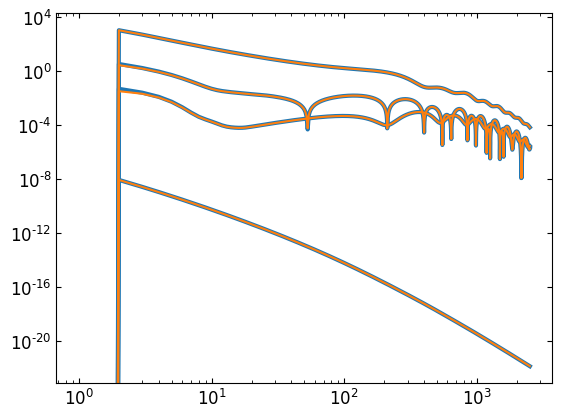

0-element Array{Any,1}

In [6]:
plot(ℓs,      WkℓTT * (Aₛ*(ks/kₚ).^(nₛ-1) .* dlnk),  lw=3, c="C0")
plot(ℓs,      WkℓEE * (Aₛ*(ks/kₚ).^(nₛ-1) .* dlnk),  lw=3, c="C0")
plot(ℓs, abs.(WkℓTE * (Aₛ*(ks/kₚ).^(nₛ-1) .* dlnk)), lw=3, c="C0")
plot(ℓs,      Wkℓϕϕ * (Aₛ*(ks/kₚ).^(nₛ-1) .* dlnk),  lw=3, c="C0")


plot(ℓs,      CℓTT,  c="C1")
plot(ℓs,      CℓEE,  c="C1")
plot(ℓs, abs.(CℓTE), c="C1")
plot(ℓs,      Cℓϕϕ,  c="C1")

loglog()

Similarly, the matter transfer functions, such that 
$$P(k) = T(k)^2 P_*(k)$$

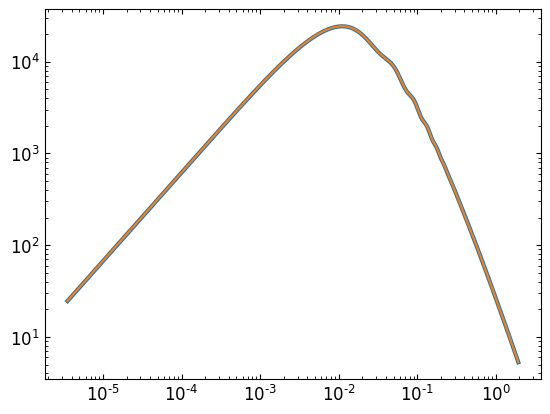

In [7]:
Tk² = interpolate((mt[:q],),mt[:transfer_data][7,:,end].^2 .* mt[:q],Gridded(Linear()))[ks]

Pk = r[:get_linear_matter_power_spectrum]()
Pk = interpolate((Pk[1],),Pk[3][1,:],Gridded(Linear()));
loglog(ks,6Tk² .* (Aₛ*(ks/kₚ).^(nₛ-1)),lw=3)
loglog(ks,Pk[ks/h]);

### Load Planck data

#### Low-ℓ

In [8]:
f = FITS("../dat/COM_PowerSpect_CMB_R2.02.fits")
tocl = 1./((2:29).*((2:29)+1)/2/pi)
d_low_TT = read(f["TTLOLUNB"],"D_ELL").*tocl
σ_low_TT = read(f["TTLOLUNB"],"ERRUP").*tocl
# σ_low = sqrt(read(f["TTLOLUNB"],"ERRUP").*read(f["TTLOLUNB"],"ERRDOWN")).*tocl
close(f) 

#### High-ℓ

In [9]:
# the binning specification
blmin, blmax = (round.(Int,readdlm("../dat/plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/bl$m.dat")) for m=["min","max"])
bweight = readdlm("../dat/plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/bweight.dat");
B_high = hcat([(r=zeros(2508); r[(30+lmin):(30+lmax)]=bweight[(1+lmin):(1+lmax)]; r) for (lmin,lmax) in take(zip(blmin,blmax),214)]...);


# the covariance
Σ_high = (open("../dat/plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/c_matrix_plik_v18.dat") do f
    read(f,Int32) #fortran header
    s = read(f,Float64,(613,613))
    (s+s') - diagm(diag(s))
end);
Σ_high_TT = Σ_high[1:214,1:214]
Σ_high_TE = Σ_high[216:414,216:414]
Σ_high_EE = Σ_high[415:end,415:end]


# the data
d_high_TT = readdlm("../dat/plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v18.dat")[1:214,2]
d_high_TE = readdlm("../dat/plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v18.dat")[216:414,2]
d_high_EE = readdlm("../dat/plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v18.dat")[415:end,2];

In [10]:
# for TT, combine low and high-L    
n_low, n_high = length(d_low_TT), length(d_high_TT)
d_planck_TT = [d_low_TT; d_high_TT]
Σ_planck_TT = [diagm(σ_low_TT.^2) zeros(n_low,n_high); zeros(n_high,n_low) Σ_high_TT]
B_planck_TT = [[zeros(1,28); eye(2507,28)] B_high]

nbinsTT = size(B_planck_TT,2);
nbinsEE = size(B_high,2);

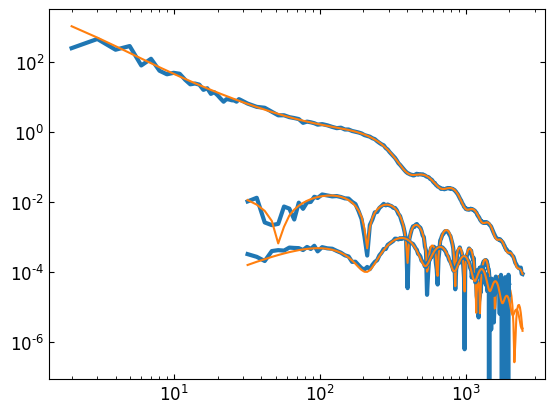

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f86803169b0>

In [11]:
#check we loaded everything right
loglog((B_planck_TT'*ℓs), d_planck_TT, C="C0", lw=3)
plot(B_planck_TT'*ℓs, B_planck_TT'*CℓTT,c="C1")

loglog((B_high'*ℓs)[1:199], abs.(d_high_TE), c="C0", lw=3)
plot(B_high'*ℓs, B_high'*abs.(CℓTE),c="C1")

loglog((B_high'*ℓs)[1:199], d_high_EE, c="C0", lw=3)
plot(B_high'*ℓs, B_high'*CℓEE,c="C1")

#### Lensing

In [12]:
d = readdlm("../dat/lensing_aggress.dat")[1:end-2,:];
d_ϕϕ = d[:,3]
Σ_ϕϕ = diagm(d[:,4].^2)
blmin,blmax = Int.(d[:,1]), Int.(d[:,2])
B_ϕϕ = hcat([(r=zeros(2508); r[lmin:lmax]=1/(lmax-lmin+1); r) for (lmin,lmax) in zip(blmin,blmax)]...);

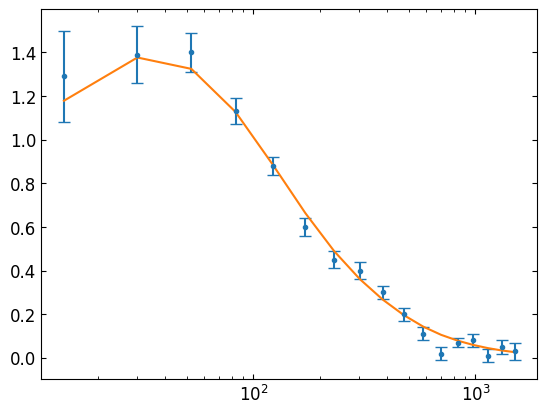

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f868019e828>

In [13]:
errorbar((blmin+blmax)/2, d_ϕϕ, sqrt.(diag(Σ_ϕϕ)),marker=".",ls="")
semilogx((blmin+blmax)/2, B_ϕϕ' * (@. 1e7 * Cℓϕϕ * (ℓs*(ℓs+1))^2/(2π)))

## Reid et al. 2010 $P_{halo}(k)$

In [14]:
iterrows(A::Matrix) = (A[i,:] for i=1:size(A,1))
itercols(A::Matrix) = (A[:,i] for i=1:size(A,2))

itercols (generic function with 1 method)

Here we call the modified version of CAMB to compute the halo matter power spectrum (instead of the linear matter power spectrum), using the fiducial cosmological parameters specified above:

In [15]:
@pyimport camb4py
camb09 = camb4py.load("../src/camb-feb09/camb",defaults="../dat/lrgdr7like/CAMBfeb09patch/params.ini")
Pk_halo = camb09(;Dict(Symbol(k)=>v for (k,v) in Dict(
    "re_optical_depth" => τ,
    "scalar_amp(1)" => Aₛ,
    "scalar_spectral_index(1)" => nₛ,
    "hubble" => H₀,
    "ombh2" => ωb,
    "omch2" => ωc,
    "pivot_scalar" => kₚ,
    "temp_cmb" => T₀
))...)["transfer_matterpower"][2:end,1:2]
Pk_halo = interpolate((Pk_halo[:,1],),Pk_halo[:,2],Gridded(Linear()));

Now we load Reid et al. 2010 data:

In [16]:
(k_reid,d_reid_Pk) = itercols(readdlm("../dat/lrgdr7like/data/lrgdr7_ccmeasurements.txt")[:,[1,4]])
Σ_reid_Pk = inv(readdlm("../dat/lrgdr7like/data/lrgdr7_invcov.txt"))
σ_reid_Pk = sqrt.(diag(Σ_reid_Pk));

Finally, we compute the best fit bias parameters:

In [17]:
Fnuis(k,b₀=1,a₁=0.172,a₂=-0.198) = (kₛ=0.2/h; b₀^2*(1+a₁*(k/kₛ)+a₂*(k/kₛ)^2))
lnL(x) = (Δ = Pk_halo[k_reid] .* Fnuis.(k_reid,x...) - d_reid_Pk; Δ'*(Σ_reid_Pk\Δ))
x_nuis_reid = optimize(lnL,Float64[1,0,0]).minimizer

3-element Array{Float64,1}:
  1.24645 
  0.564531
 -0.354702

## Lyman-alpha forest

In [112]:
function rebin(xs,σs,nperbin)
    istart = cumsum([0; nperbin])[1:end-1]+1
    (tuple(([         mean(x[i:i+n-1])     for (i,n) in zip(istart,nperbin)] for x in xs)...),
     tuple(([sqrt(1/sum(1./σ[i:i+n-1].^2)) for (i,n) in zip(istart,nperbin)] for σ in σs)...))
end

rebin (generic function with 1 method)

In [117]:
k_lyaf, Pk_lyaf, σ_lyaf_Pk    = itercols(readdlm("../dat/lya/pm_z0_final.txt"));
(k_lyaf,Pk_lyaf),(σ_lyaf_Pk,) = rebin((k_lyaf,Pk_lyaf),(σ_lyaf_Pk,), [fill(1,7); [2,2,2,2,3,3,3,4,4]]);

## Make plot

In [118]:
function ebar(Pi)
    cs = cumsum(abs.(Pi) .* dlnk)
    cs /= cs[end]
#     semilogx(ks/h,cs)
    inz = @. (cs>0) & (cs<1)
    itp = interpolate((cs[inz],),ks[inz],Gridded(Linear()))
    itp[[0.2,0.5,0.8]]
end

function get_plot_data(d, Σ, B, Cℓ, Wkℓ, nrebin)
    
    # rebin the data
    lmins = cumsum([1; nrebin])[1:end-1]
    lims = zip(lmins,lmins+nrebin-1)
    nbins = size(B,2)
    B2 = hcat([(r=zeros(nbins); r[l1:l2]=1; normalize!(r,1)) for (l1,l2)=lims]...);
    nbins2 = size(B2,2)
    
    # compute 
    Wki = B2'*B'*Wkℓ ./ Tk²'
    Pi = Wki ./ sum(Wki .* dlnk',2)
    ℓkmap = hcat(map(ebar,(Pi[i,:] for i=1:nbins2))...)'
    
    σCℓ_over_Cℓ = sqrt.(diag(B2'*Σ*B2)) ./ (B2'*d)
    f = (B2' * d) ./ (B2' * B' * Cℓ)
    
    σCℓ_over_Cℓ, ℓkmap, f, Pi
    
end
    
function make_plot(σCℓ_over_Cℓ, ℓkmap, f, args...; kwargs...)
    
    # make plot
    m = Pk[ℓkmap[:,2]/h]
    errorbar(
        ℓkmap[:,2]/h, 
        m .* f;
        yerr = m .* σCℓ_over_Cℓ,
        xerr = abs.(ℓkmap[:,[1,3]].-ℓkmap[:,2])'/h,
        marker = ".", 
        ls = "", 
        kwargs...
    )
    
end

make_plot (generic function with 1 method)

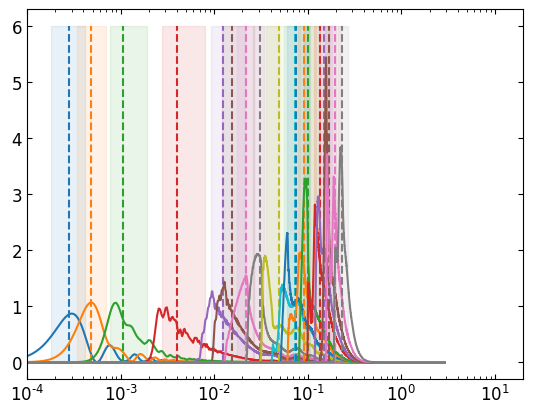

(0.0001, 20.0)

In [119]:
_,ℓkmap,_,Pi = get_plot_data(d_planck_TT, Σ_planck_TT, B_planck_TT,     CℓTT, WkℓTT, [[1, 3, 15, 15]; fill(5,2); fill(10,5); fill(20,7)])
# _,ℓkmap,_,Pi = get_plot_data(d_high_EE,   Σ_high_EE,   B_high[:,1:199], CℓEE, WkℓEE, [fill(5,2); fill(10,5); fill(20,6); 19])
# _,ℓkmap,_,Pi = get_plot_data(d_high_TE,   Σ_high_TE,   B_high[:,1:199], CℓTE, WkℓTE, [fill(5,2); fill(10,5); fill(20,6); 19])
# _,ℓkmap,_,Pi = get_plot_data(d_ϕϕ,   Σ_ϕϕ,   B_ϕϕ, Cℓϕϕ, Wkℓϕϕ, [1,1,2,2,2,3,3,3])


for i = 1:size(ℓkmap,1)
    l, = semilogx(ks/h,Pi[i,:])
    plot(fill(ℓkmap[i,2],2)/h,[0,6],c=l[:get_color](),"--")
    fill_betweenx([0,6], fill(ℓkmap[i,1],2)/h, fill(ℓkmap[i,3],2)/h, color=l[:get_color](), alpha=0.1)
end
xlim(1e-4,2e1)

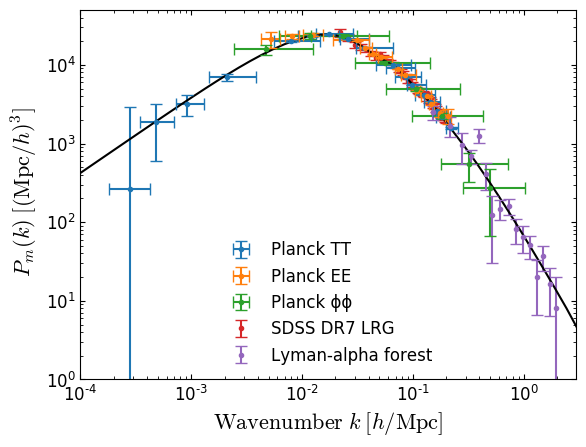

In [123]:
ks′ = logspace(-4,1)
plot(ks′,Pk[ks′],"k")


make_plot(get_plot_data(d_planck_TT, Σ_planck_TT, B_planck_TT,     CℓTT, WkℓTT, [[1, 3, 5, 20]; fill(5,2); fill(10,5); fill(20,7)])..., label="Planck TT")
make_plot(get_plot_data(d_high_EE,   Σ_high_EE,   B_high[:,1:199], CℓEE, WkℓEE, [fill(5,2); fill(10,5); fill(20,6); 19])..., label="Planck EE")
# make_plot(get_plot_data(d_high_TE,   Σ_high_TE,   B_high[:,1:199], CℓTE, WkℓTE, [fill(5,2); fill(10,5); fill(20,6); 19])..., label="Planck TE")
make_plot(get_plot_data(d_ϕϕ, Σ_ϕϕ, B_ϕϕ, (@. 1e7 * Cℓϕϕ * (ℓs*(ℓs+1))^2/(2π)), Wkℓϕϕ, [1,1,2,2,2,3,3,3])..., label="Planck ϕϕ")

α_reid = 1 ./ Fnuis.(k_reid,x_nuis_reid...) .* (Pk[k_reid]./Pk_halo[k_reid])
errorbar(k_reid, α_reid .* d_reid_Pk, yerr=(α_reid .* σ_reid_Pk), marker=".", ls="", zorder=-1, label="SDSS DR7 LRG")


errorbar(k_lyaf, Pk_lyaf, yerr = σ_lyaf_Pk, ls="", marker=".",  label="Lyman-alpha forest")


xscale("log")
yscale("log")
legend(loc="lower center")

xlim(1e-4,3)
ylim(1,5e4)

ylabel(raw"$\; P_m(k) \; [({\rm Mpc}/h)^3]$")
xlabel(raw"${\rm Wavenumber} \; k \; [h/{\rm Mpc}]$")

savefig("tegfig.pdf", bbox_inches="tight")